## Layers API

I'm going to re-build the model I built in `2017-10-15-football-cnn.ipynb` using TF's layers API following the outline of [this tutorial](https://www.tensorflow.org/tutorials/layers)

In [70]:
# Imports
import numpy as np
import tensorflow as tf
import scipy.ndimage
from scipy.misc import imsave
import matplotlib.pyplot as plt

%matplotlib inline

tf.logging.set_verbosity(tf.logging.INFO)

## Training Data

I have already generated my training data in the football-cnn notebook. The code below loads the data and coerces it into the expected format and shape for this tutorial

In [30]:
# NOTE: I changed this to utilize an SSD I have on this box. Should be: data/football/*.npy

train_x = np.load('data/serialized/train_x.npy')
train_y = np.load('data/serialized/train_y.npy')

test_x  = np.load('data/serialized/test_x.npy')
test_y  = np.load('data/serialized/test_y.npy')

In [2]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [8]:
mnist.train.images[0].reshape(28, 28, 1)

array([[[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [

In [37]:
train_x[0].astype(np.float32)

array([[[  6.14448214e+00],
        [  5.45331812e+00],
        [  4.62267208e+00],
        ..., 
        [  3.94850636e+00],
        [  2.33470821e+00],
        [  4.33133364e+00]],

       [[  6.21147346e+00],
        [  5.51168585e+00],
        [  3.63454556e+00],
        ..., 
        [  5.09798765e+00],
        [  4.46894121e+00],
        [  4.01612282e+00]],

       [[  4.90901136e+00],
        [  4.18060255e+00],
        [  3.30871153e+00],
        ..., 
        [  1.03087115e+00],
        [  5.73678315e-01],
        [  1.36270463e+00]],

       ..., 
       [[ -1.47481561e-02],
        [ -1.49981249e-02],
        [ -1.53730782e-02],
        ..., 
        [  2.48693905e+01],
        [  2.44659424e+01],
        [  2.63889523e+01]],

       [[ -1.34983128e-02],
        [ -1.33733284e-02],
        [ -1.46231716e-02],
        ..., 
        [  2.38996372e+01],
        [  2.25821781e+01],
        [  2.60030003e+01]],

       [[ -1.38732661e-02],
        [ -1.37482816e-02],
        [ -

In [46]:
# NOTE: the model expects only float 32?!?
train_x = train_x.astype(np.float32)
test_x  = test_x.astype(np.float32)

In [18]:
np.asarray(mnist.train.labels, dtype=np.int32)

array([7, 3, 4, ..., 5, 6, 8], dtype=int32)

In [32]:
# This tutorial does one hot encoding a bit different than the last one.
# train_y labels are [x, y] when x == 1, the label is game
labels = [ label[0] for label in train_y ]
train_y = np.asarray(labels, dtype=np.int32)
print("count labels %s" % len(train_y))
print("Count game labels %s" % sum(train_y))
train_y

count labels 8000
Count game labels 4000


array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [31]:
labels = [ label[0] for label in test_y ]
test_y = np.asarray(labels, dtype=np.int32)
print("count labels %s" % len(test_y))
print("Count game labels %s" % sum(test_y))
test_y

count labels 2000
Count game labels 1000


array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [155]:
def football_model_fn(features, labels, mode):
    """Trains a model to predict if an image is a picture of a football game or not
    
    Graph:
    Follows from my previous, lower level, tutorial in 2017-10-15-football-cnn.ipynb
    conv1_1 => conv1_2 => pool1 => conv2_1 => conv2_2 => pool2 => connected => output
    """
    num_classes = 2
    keepRate1 = 1.
    keepRate2 = 1.
    alpha = 1e-3

    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 240, 320, 1])

    conv1_1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu,
        name="conv1_1"
    )
    
    # Mine:
    # shape: [batch_size, 240, 320, 32]
    
    conv1_2 = tf.layers.conv2d(
        inputs=conv1_1,
        filters=32,
        kernel_size=[3,3],
        padding="same",
        activation=tf.nn.relu,
        name="conv1_2"
    )
    
    # Mine:
    # shape: [batch_size, 240, 320, 32]

     # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(
        inputs=conv1_2, 
        pool_size=[2, 2], 
        strides=[2, 2],
        padding="same",
        name="pool1"
    )
    
    pool1_1_drop = tf.layers.dropout(
        inputs=pool1,
        rate=(1 - keepRate1),
        name="pool1_1_drop"
    )
   
    # Tutorial:
    # Our output tensor produced by max_pooling2d() (pool1) has a shape of [batch_size, 14, 14, 32]: 
    # the 2x2 filter reduces width and height by 50% each.

    # Mine:
    # shape: [batch_size, 120, 160, 32]

    # Convolutional Layer #2 and Pooling Layer #2
    conv2_1 = tf.layers.conv2d(
        inputs=pool1_1_drop,
        filters=64,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.sigmoid,
        name="conv2_1"
    )
    
    conv2_2 = tf.layers.conv2d(
        inputs=conv2_1,
        filters=64,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu,
        name="conv2_2"
    )
    
    pool2 = tf.layers.max_pooling2d(
        inputs=conv2_2,
        pool_size=[2, 2],
        strides=[2, 2],
        padding="same",
        name="pool2"
    )
    
    pool2_drop = tf.layers.dropout(
        inputs=pool2,
        rate=(1 - keepRate2),
        name="pool2_drop"
    )

    # Tutorial:
    # pool2 has shape [batch_size, 7, 7, 64] (50% reduction of width and height from conv2).

    # Mine:
    # shape: [batch_size, 60, 80, 64]

    # Fully Connected Layer

    pool2_flat = tf.reshape(pool2_drop, [-1, 60 * 80 * 64])

    fc1 = tf.layers.dense(
        inputs=pool2_flat,
        units=512,
        activation=tf.nn.relu,
        name="fc1"
    )
    
    dropout = tf.layers.dropout(
        inputs=fc1,
        rate=0.4,
        training=mode == tf.estimator.ModeKeys.TRAIN
    )

    # Tutorial:
    # Reduces 3136 (7 * 7 * 64) to 1024 in this dense layer

    # Mine:
    # Reduces 307200 (60 * 80 * 64) to 512 in this dense layer

    # Output Layer
    output = tf.layers.dense(
        inputs=dropout, 
        units=num_classes
    )

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=output, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(output, name="softmax_tensor")
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode,
                                          predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=num_classes)
    
    loss = tf.losses.softmax_cross_entropy(
      onehot_labels=onehot_labels, logits=output)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=alpha)
        
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(labels=labels,
                                      predictions=predictions["classes"]),
      "precision" : tf.metrics.precision(labels=labels,
                                 predictions=predictions["classes"])
    }

    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [156]:
# NOTE: this mimick's the "__main__" function the tutorial is creating
# Create the Estimator
football_classifier = tf.estimator.Estimator(model_fn=football_model_fn,
                                             model_dir="/tmp/fball_convnet_model")

tensors_to_log = {"probabilities": "softmax_tensor"}
tensors_to_log = {}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, 
                                          every_n_iter=50 # 50
                                         )

# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_x},
    y=train_y,
    batch_size=200,
    num_epochs=None,
    shuffle=True)

football_classifier.train(
    input_fn=train_input_fn,
    #steps=20, # 20000
    hooks=[logging_hook])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/fball_convnet_model', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/fball_convnet_model/model.ckpt.
INFO:tensorflow:probabilities = [[ 0.73524559  0.26475438]
 [ 0.7351054   0.26489466]
 [ 0.7880407   0.21195935]
 [ 0.70135099  0.29864901]
 [ 0.33616385  0.66383612]
 [ 0.28594604  0.71405393]
 [ 0.5676136   0.43238646]
 [ 0.35253808  0.64746195]
 [ 0.4282738   0.57172626]
 [ 0.40256256  0.59743744]]
INFO:tensorflow:loss = 0.851107, step = 1
INFO:tensorflow:probabilities = [[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]] (9.961 sec)
INFO:tensorflow:probabili

In [157]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": test_x},
    y=test_y,
    num_epochs=1,
    shuffle=False)

eval_results = football_classifier.evaluate(input_fn=eval_input_fn)

print(eval_results)

INFO:tensorflow:Starting evaluation at 2017-10-22-16:09:22
INFO:tensorflow:Restoring parameters from /tmp/fball_convnet_model/model.ckpt-20
INFO:tensorflow:Finished evaluation at 2017-10-22-16:11:09
INFO:tensorflow:Saving dict for global step 20: accuracy = 0.5, global_step = 20, loss = 15.2855, precision = 0.5
{'accuracy': 0.5, 'loss': 15.285529, 'precision': 0.5, 'global_step': 20}


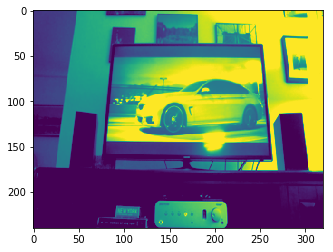

In [142]:
# Prediction:
# Evaluate the model and print results
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": test_x[-5:-1]}, #.reshape(6, 240, 320, 1)},
    num_epochs=1,
    shuffle=False)

predict_results = football_classifier.predict(input_fn=predict_input_fn)

plt.imshow(test_x[-1].reshape(240, 320))

In [143]:
for result in predict_results:
    res = ""
    res += "game" if result['classes'] == 1 else "Not Game"
    print(res + " " + str([ round(prob * 100) for prob in result['probabilities']]))

INFO:tensorflow:Restoring parameters from /tmp/fball_convnet_model/model.ckpt-20
game [0.0, 100.0]
game [0.0, 100.0]
game [0.0, 100.0]
game [0.0, 100.0]


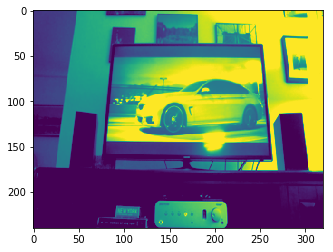

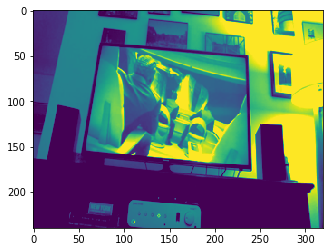

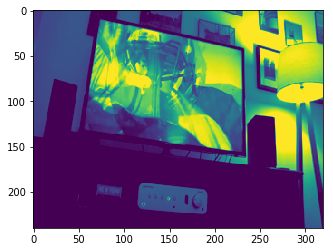

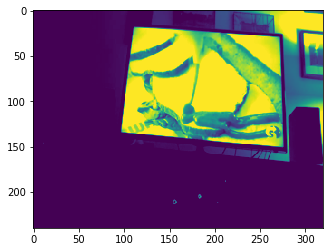

In [121]:
for i in range(-1, -5, -1):
    plt.imshow(test_x[i].reshape(240, 320))
    plt.show()